# 1. Import Library

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder

figsize = (12, 8)

# 2. Reading Data

In [68]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# 3. Data Overview
- Về Shape:
    - Dữ liệu lớn cỡ nào?
- Về Data Types:
    - Dữ liệu định dạng đúng chưa?
- Về **ý nghĩa**:
    - Một dòng đại diện cho cái gì?

## Detail columns
- **id**: Mã định danh của khách hàng
- **annual_income**: Thu nhập hàng năm của người vay (USD)
- **debt_to_income_ratio**: Tỉ lệ nợ trên thu nhập (DTI). Các điều kiện tiên quyết:
    - **Dưới 36%**: Tốt
    - **36% - 49%**: Trung bình
    - **Trên 49%**: Xấu
- **credit_score**: Điểm tín dụng (điểm càng cao thì càng tốt)
- **loan_amount**: Tổng tiền vay
- **interest_rate**: Lãi suất vay
- **gender**: Giới tính
- **marial_status**: Tình trạng hôn nhân
- **education_level**: Trình độ học vấn
- **employment_status**: Tình trạng việc làm
- **loan_purpose**: Mục đích vay
- **grade_subgrade**: Hạng tín dụng
- **loan_paid_back**: Trạng thái trả nợ

In [69]:
shape = train.shape
print(f"Rows: {shape[0]} - Columns: {shape[1]}")

Rows: 593994 - Columns: 13


In [70]:
train.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

In [71]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


- Từng dòng chính là thông tin của một người về thu nhập và số tiền vay, cũng như điểm tín dụng và các thông tin khác. Đặc biệt là người đó có trả nợ hay vỡ nợ

# 4. Data Preparation
- Missing Values
- Duplicated Value
- Dropping irrelevant columns or rows
- Change Name

### Check missing and duplicate

In [72]:
is_null = all(train.isnull().sum() != 0)
is_duplicated = int(train.duplicated().sum()) != 0

print(f"Data is null? -> {is_null}\nData is duplicated? -> {is_duplicated}")

Data is null? -> False
Data is duplicated? -> False


- Dữ liệu không bị Null hoặc không bị duplicated
- Việc tiếp theo sẽ là bỏ bớt các cột không sử dụng

### Drop irrelevant columns

In [73]:
train = train[['annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back']]

### Change Name

In [74]:
train.rename(columns={
    "annual_income": "Annual Income",
    "debt_to_income_ratio": "DTI ratio",
    "credit_score": "Credit Score",
    "loan_amount": "Loan Amount",
    "education_level": "Education",
    "employment_status": "Employment",
    "loan_purpose": "Purpose",
    "grade_subgrade": "Grade",
    "loan_paid_back": "Loan Paid Back"
}, inplace=True)

In [75]:
train.head()

,Annual Income,DTI ratio,Credit Score,Loan Amount,Education,Employment,Purpose,Grade,Loan Paid Back
0,29367.99,0.084,736,2528.42,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,High School,Employed,Other,D1,1.0


# 5. EDA

## 5.1 Feature Understanding
- **Numerical Variable:**
    - **Distribution:** Dữ liệu có bị lệch (skewed) hay phân phối chuẩn (normal)?
    - **Outliers:** Có giá trị outliers không?
- **Categorical:**
    - **Imbalanced:** Có bị chiếm áp đảo không?

### 5.1.A Numerical Variable

In [76]:
numerical_data = train[['Annual Income', 'DTI ratio', "Credit Score", "Loan Amount"]]

#### Distribution

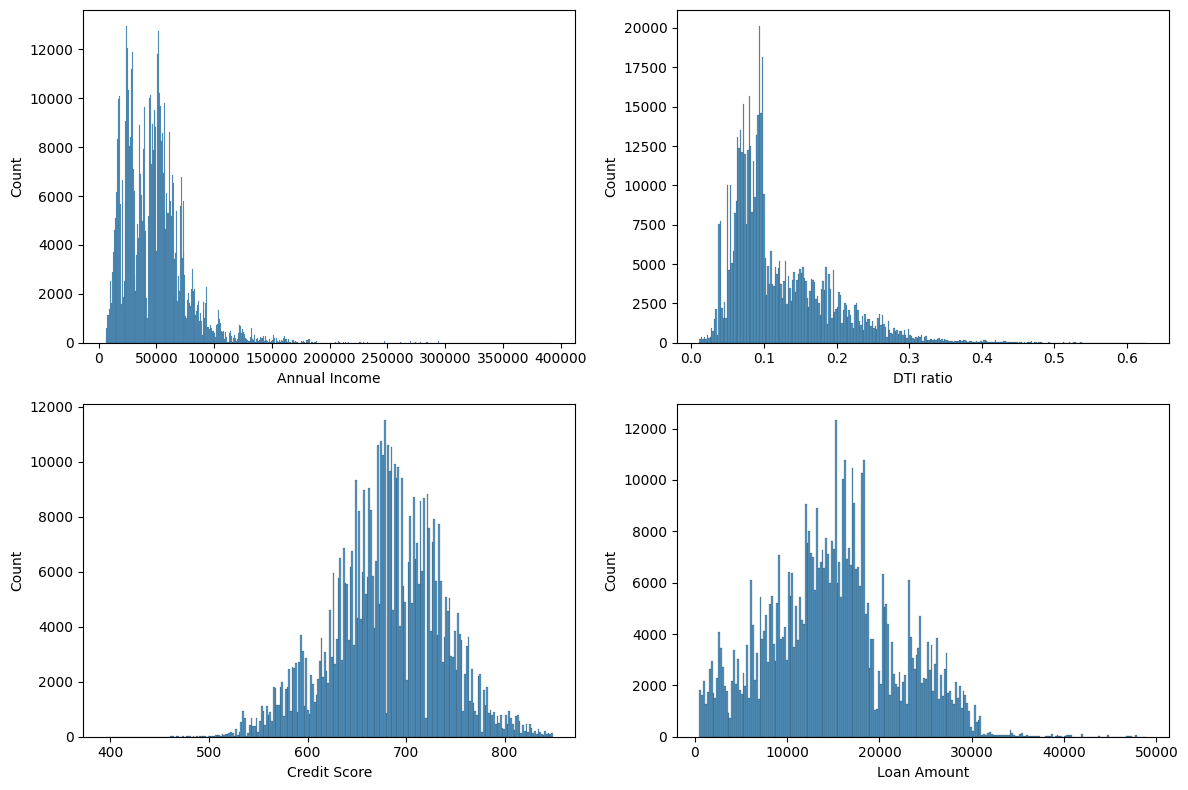

In [90]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.histplot(numerical_data, x='Annual Income', ax=ax[0, 0])
sns.histplot(numerical_data, x='DTI ratio', ax=ax[0, 1])
sns.histplot(numerical_data, x='Credit Score', ax=ax[1, 0])
sns.histplot(numerical_data, x='Loan Amount', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Annual Income** đang bị lệch về trái &rarr; hầu hết đều là người thu nhập thấp và trung bình
- **DTI ratio** đang lệch về trái &rarr; đây là tín hiệu rất tốt vì khả năng trả nợ là rất cao
- **Credit Score** đang lệch về phải &rarr; có sự tương đồng với **DTI ratio** (Điểm càng cao càng tốt và nó ngược lại với DTI)
- **Loan Amount** lệch trái một cút &rarr; hầu hết mọi người đang vay nợ tầm trung

#### Outliers

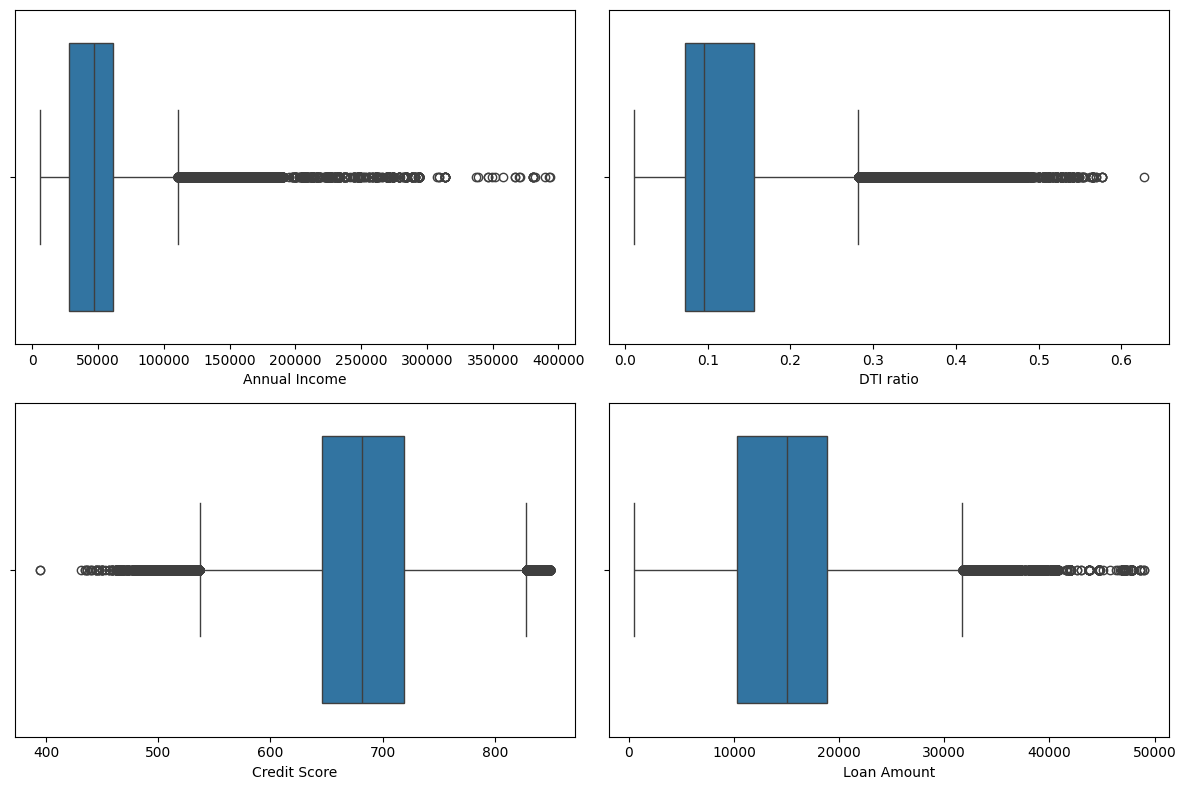

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.boxplot(numerical_data, x='Annual Income', ax=ax[0, 0])
sns.boxplot(numerical_data, x='DTI ratio', ax=ax[0, 1])
sns.boxplot(numerical_data, x='Credit Score', ax=ax[1, 0])
sns.boxplot(numerical_data, x='Loan Amount', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Annual Income** đang có rất nhiều outliers (Có nên cắt bỏ các outliers này không?)
- **Other** đều có Outliers nhưng tạm chấp nhận được (Rất ít)

### 5.1.B Categorical

In [ ]:
categorical_data = train[['Education', 'Employment', 'Purpose', 'Grade']]

#### Cardinality

In [ ]:
print(f"Unique class in Education: {list(categorical_data['Education'].unique())}")
print(f"Unique class in Employment: {list(categorical_data['Employment'].unique())}")
print(f"Unique class in Purpose: {list(categorical_data['Purpose'].unique())}")
print(f"Unique class in Grade: {list(categorical_data['Grade'].unique())}")

Unique class in Education: ['High School', "Master's", "Bachelor's", 'PhD', 'Other']
Unique class in Employment: ['Self-employed', 'Employed', 'Unemployed', 'Retired', 'Student']
Unique class in Purpose: ['Other', 'Debt consolidation', 'Home', 'Education', 'Vacation', 'Car', 'Medical', 'Business']
Unique class in Grade: ['C3', 'D3', 'C5', 'F1', 'D1', 'D5', 'C2', 'C1', 'F5', 'D4', 'C4', 'D2', 'E5', 'B1', 'B2', 'F4', 'A4', 'E1', 'F2', 'B4', 'E4', 'B3', 'E3', 'B5', 'E2', 'F3', 'A5', 'A3', 'A1', 'A2']


- Vì Grade chiếm ưu thế và có thứ tự nên sẽ sắp xếp lại theo thứ tự bên grade

In [102]:
categorical_data.sort_values(by=['Grade'], axis=0, inplace=True)

C:\Users\hungm\AppData\Local\Temp\ipykernel_4868\1913654876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_data.sort_values(by=['Grade'], axis=0, inplace=True)


#### Distribution

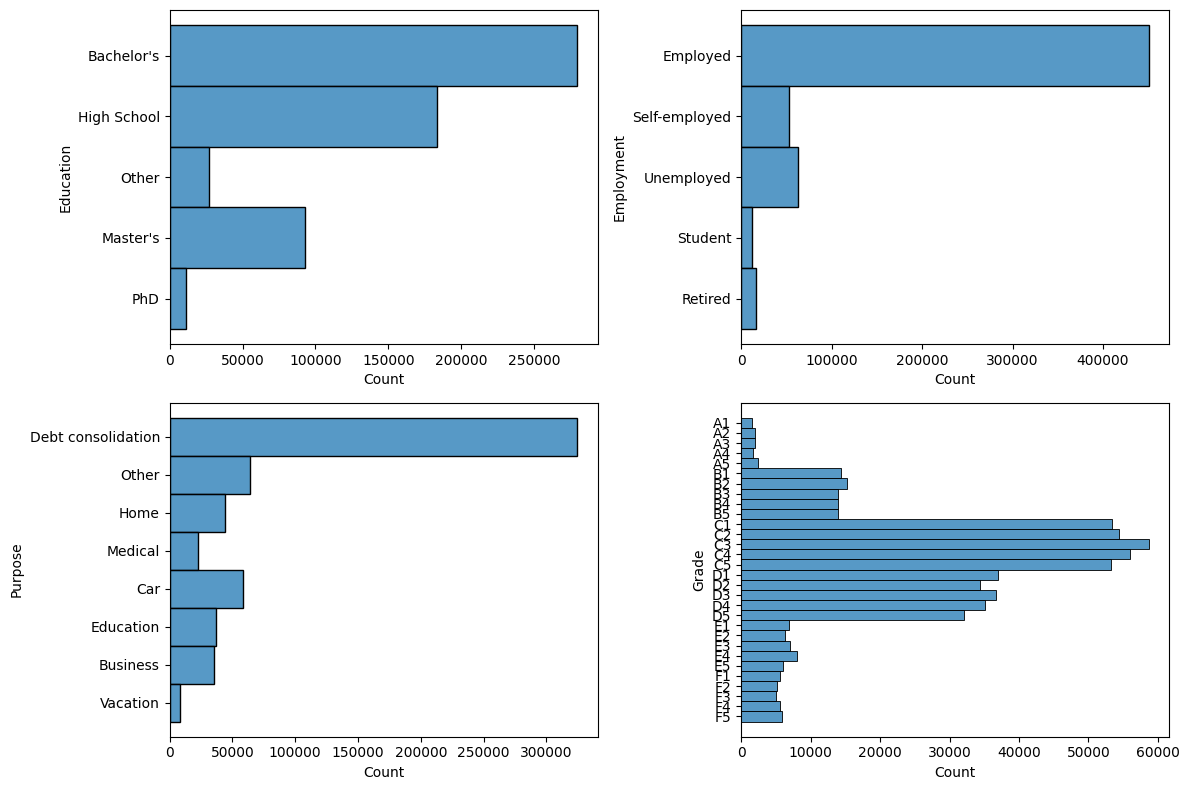

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)

sns.histplot(categorical_data, y='Education', ax=ax[0, 0])
sns.histplot(categorical_data, y='Employment', ax=ax[0, 1])
sns.histplot(categorical_data, y='Purpose', ax=ax[1, 0])
sns.histplot(categorical_data, y='Grade', ax=ax[1, 1])

fig.tight_layout()
plt.show()

- **Education:** Hầu hết đều là Banchelor và High School
- **Employment:** Chiếm phần lớn nhất là Employed
- **Purpose:** Mục đích chiếm nhiều nhất là Debt consolidation
- **Grade:** Đa số mọi người đều có mức hạng trung bình, hạng tốt chỉ chiếm rất ít, còn lại là hạng thấp (đa số không thể trả)

## 5.2 Feature Relationship
- Correlation
- Redudancy
- **Relationship with Target**